<a href="https://colab.research.google.com/github/kaantopcu/Reverse-Image-Search/blob/main/notebooks/Caltech101_Similarity_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import numpy as np
from numpy.linalg import norm
import pickle
import time
from tqdm import tqdm, tqdm_notebook
import torchvision.datasets as datasets
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.decomposition import PCA
import gdown
import shutil
from sklearn.manifold import TSNE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Similarity Search

In [3]:
filenames = pickle.load(open("/content/drive/MyDrive/DataProjects/Reverse_Image_Search/filenames-caltech101.pickle",'rb'))
feature_list = pickle.load(open("/content/drive/MyDrive/DataProjects/Reverse_Image_Search/features-caltech101-resnet50.pickle",'rb'))
class_ids = pickle.load(open("/content/drive/MyDrive/DataProjects/Reverse_Image_Search/class_ids-caltech101.pickle",'rb'))

In [4]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [5]:
neighbors = NearestNeighbors(n_neighbors = 5, algorithm = 'brute', metric = 'euclidean').fit(feature_list)

In [12]:
root_dir = "/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101"

In [17]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

In [18]:
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [19]:
filenames = sorted(get_file_list(root_dir))
filenames

['/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0001.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0002.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0003.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0004.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0005.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0006.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0007.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0008.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0009.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/Faces/image_0010.jpg',
 '/content/drive/MyDrive/DataProjects/Reverse_Image_Search/caltech101/

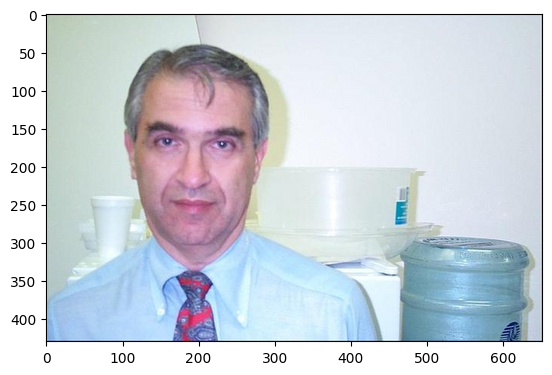

In [20]:
random_index = 100
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

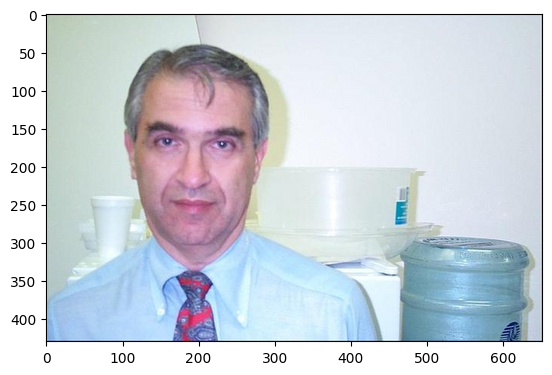

In [21]:
# Nearest neighbor
plt.imshow(mpimg.imread(filenames[indices[0][0]]), interpolation='lanczos')

In [22]:
for i in range(5):
    print(distances[0][i])

0.0
0.5798901083035324
0.6251778349597914
0.6315436652695682
0.636691625286461


Note the distance of the query image to the first closest image is zero, again showing that the closest image to the query image is the same image.

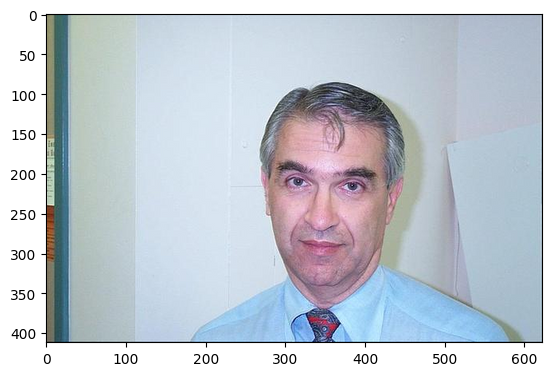

In [23]:
# Actual nearest neighbor
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')

In [24]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    num_images = len(filenames)
    columns = 4
    rows = (num_images // columns) + 1  # Cast to integer
    fig = plt.figure(figsize=(15, 10))
    for i, image in enumerate(images):
        ax = plt.subplot(rows, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

In [27]:
for i in range(3):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

IndexError: list index out of range

## Image Clusters with t-SNE

Since we have 2048 feature vector, it is needed to reduce the dimensions. t-distributed stochastic neighbor embedding (t-SNE) reduces high-dimensional feature vector to 2D. But it is difficult to scale large datasets. so firt apply PCA then call t-SNE.

In [29]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.1679046000849544
Max distance between all photos:  1.359444978162457
Median distance among most similar photos:  0.6735189419598238


In [30]:
selected_features = feature_list[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

verbose ne,

nearest neighbors'daki brute ne

In [31]:
# Convert the list to a numpy array
selected_features = np.array(selected_features)
tsne_results = TSNE(n_components = 2, verbose = 1, metric='euclidean').fit_transform(selected_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.006s...
[t-SNE] Computed neighbors for 4000 samples in 1.832s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.218704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.213623
[t-SNE] KL divergence after 1000 iterations: 1.103010


<ipython-input-32-ae7998a04c06>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm')


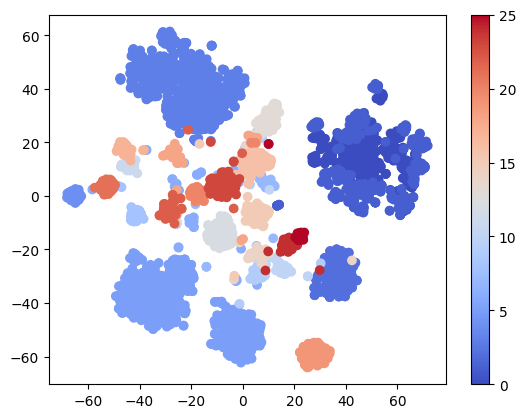

In [32]:
# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1],c=selected_class_ids,cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

To visualize images themselves

In [33]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import Image

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100))
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [34]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

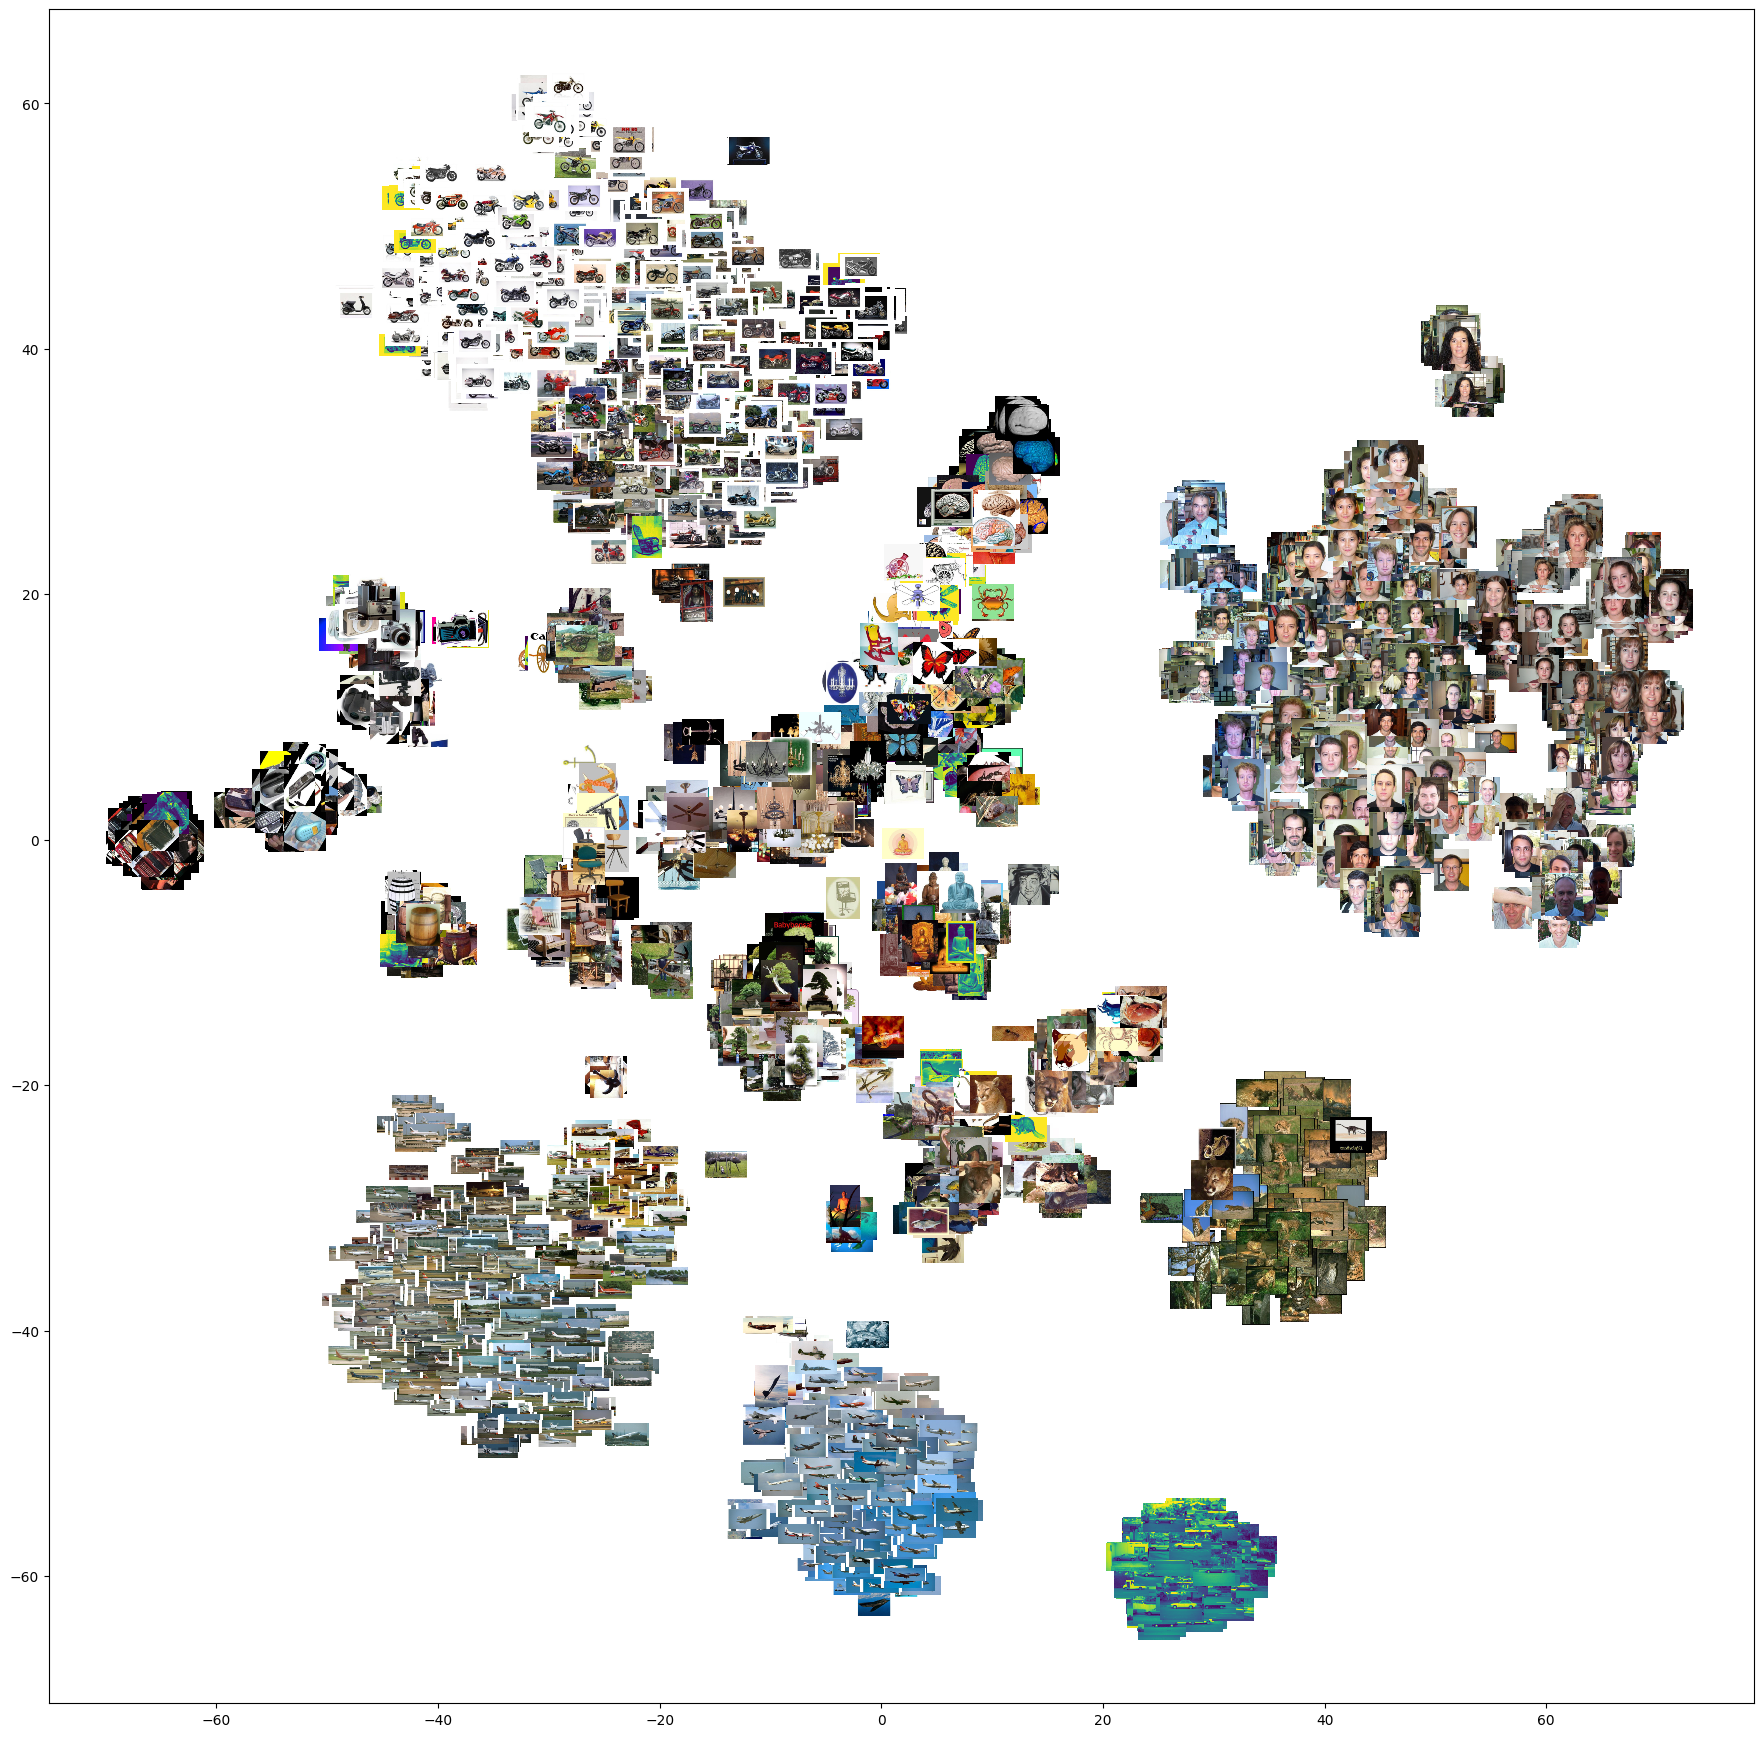

In [36]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [37]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

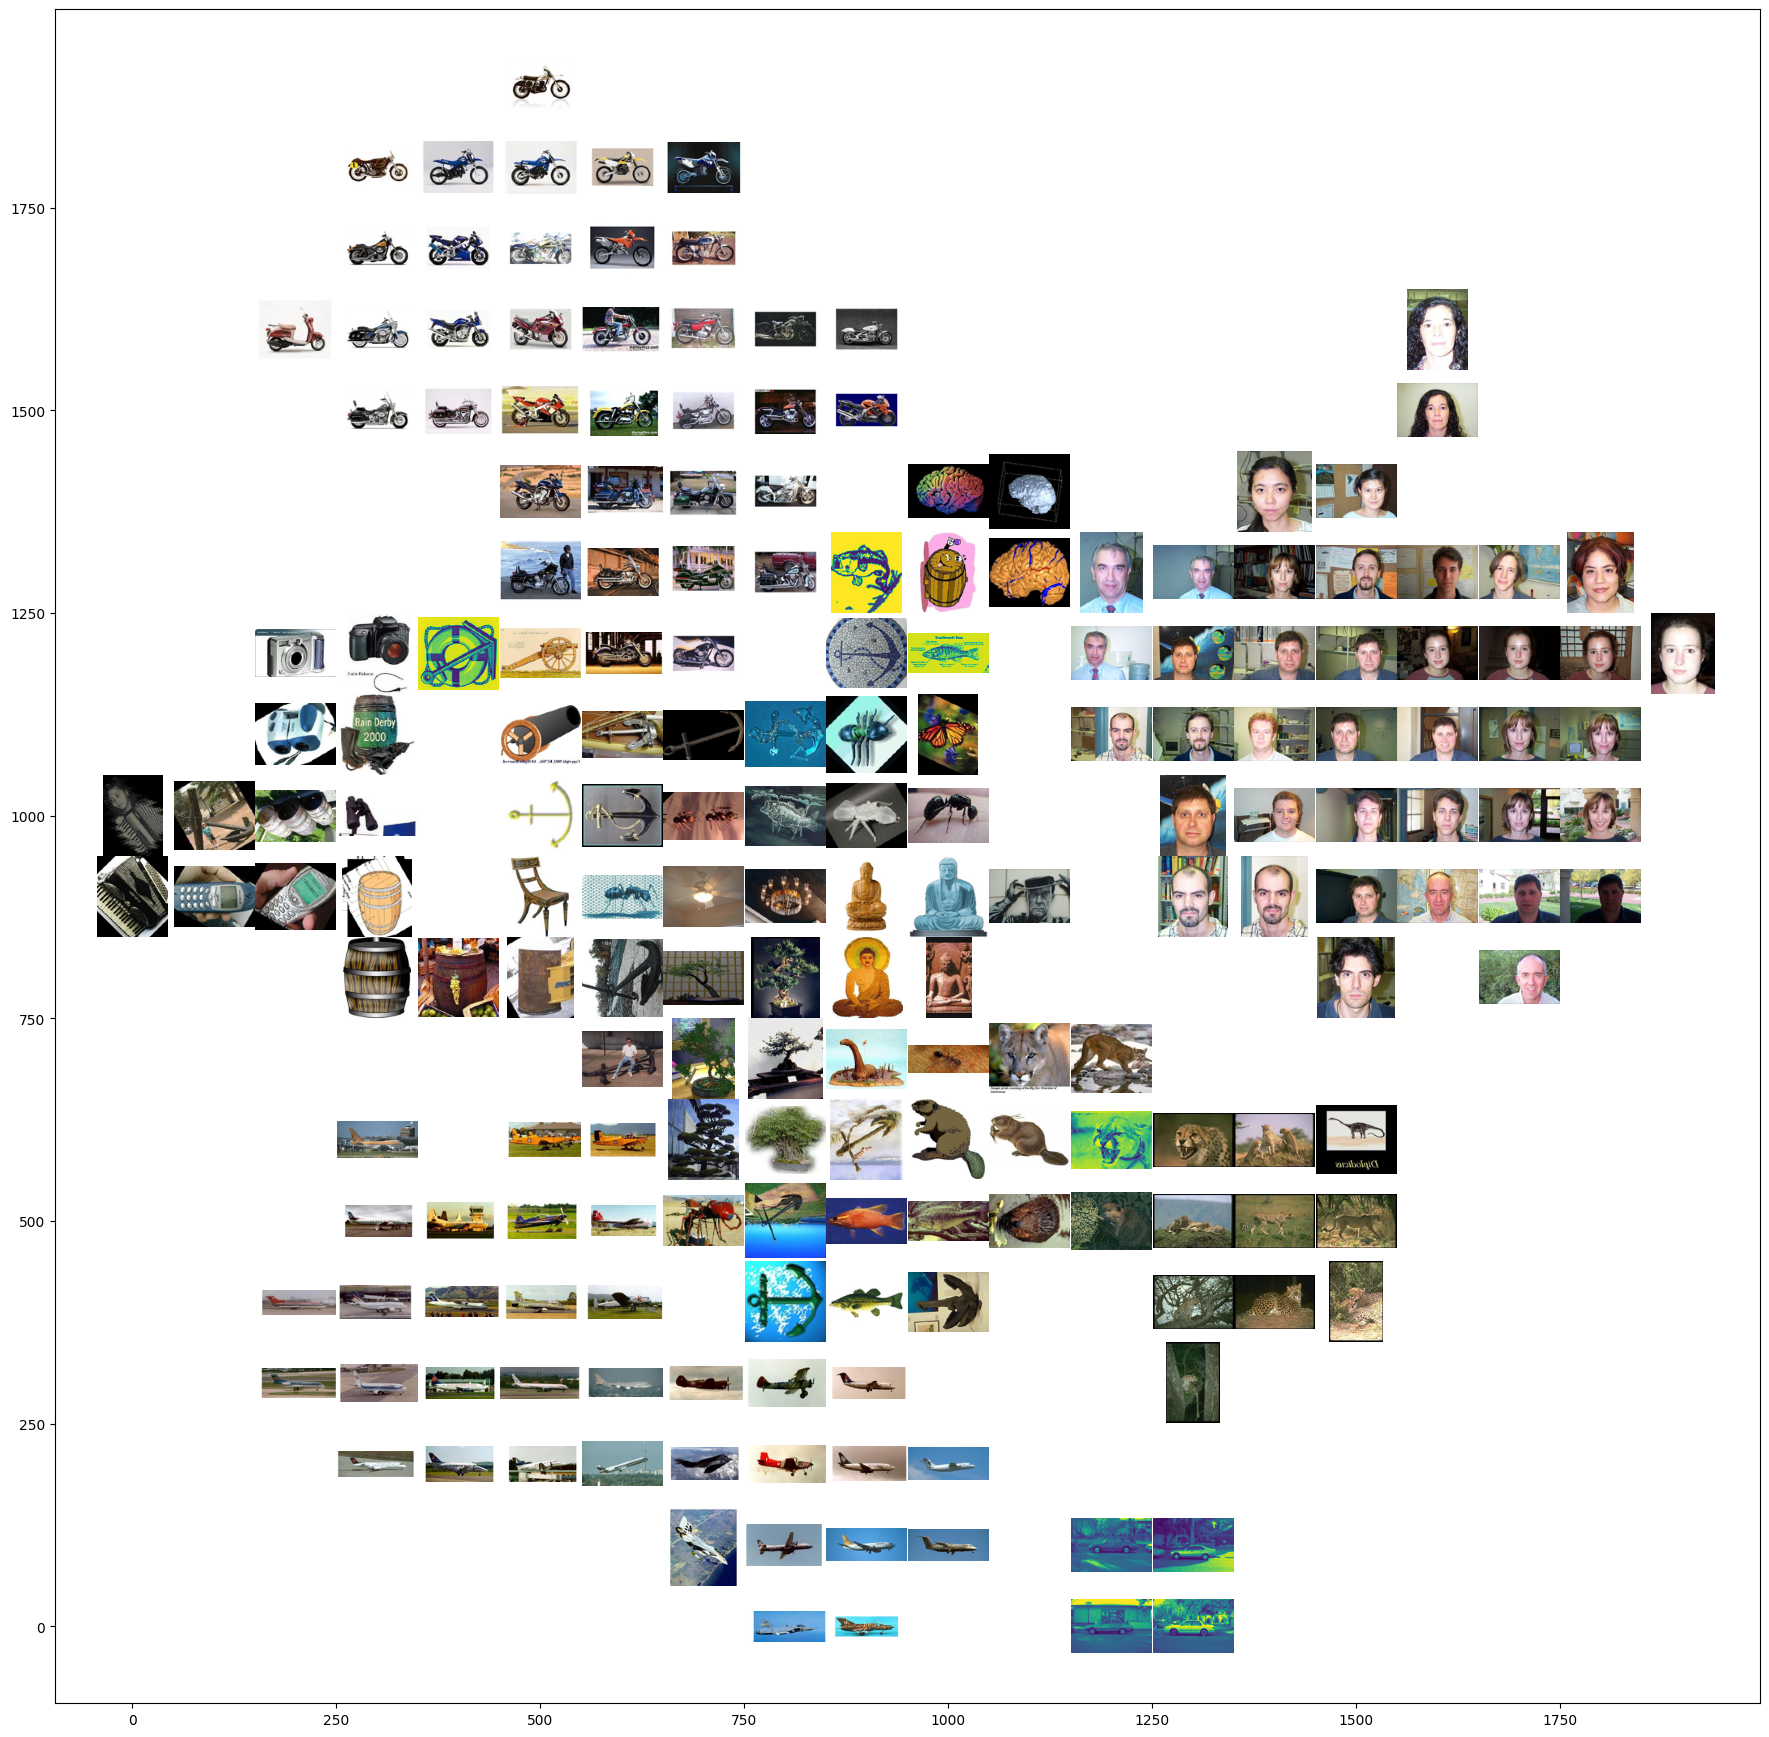

In [38]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)

## PCA

## PCA Dimension Selection

How to choose the number of pca dimension. It can be explained by the variance vs dimension count

In [39]:
pca = PCA(200)
pca.fit(feature_list)

PCA(n_components=200)

In [40]:
# Explain the importance of first 20 features
print(pca.explained_variance_ratio_[0:20])

[0.07270943 0.05200773 0.04315869 0.03535411 0.02177504 0.02061725
 0.0200197  0.01738707 0.01590189 0.01543361 0.01444921 0.01333165
 0.01225071 0.01142107 0.01101222 0.00995359 0.0096313  0.00920665
 0.00904564 0.00896294]


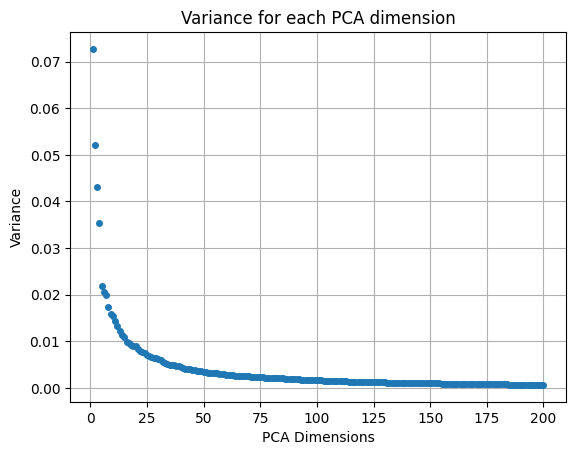

In [41]:
plt.plot(range(1,201),pca.explained_variance_ratio_, 'o', markersize = 4)
plt.title('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

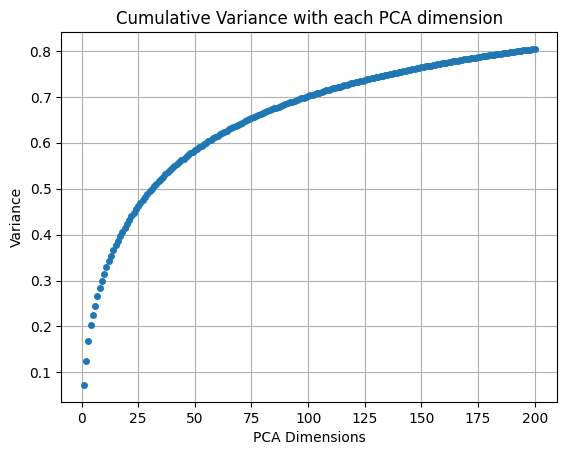

In [42]:
plt.plot(range(1,201),pca.explained_variance_ratio_.cumsum(), 'o', markersize = 4)
plt.title('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

In [43]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_predictions = 0
    incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_predictions += 1
            else:
                incorrect_predictions += 1
    print(
        "Accuracy is ",
        round(
            100.0 * correct_predictions /
            (1.0 * correct_predictions + incorrect_predictions), 2))

In [44]:
pca_dimensions = [1,2,3,4,5,10,20,50,75,100,150,200]
pca_accuracy = []
pca_time = []

In [45]:
for dimensions in pca_dimensions:
    pca = PCA(n_components = dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])

    # Calculate the accuracy over the compressed features
    accuracy = calculate_accuracy(feature_list_compressed[:])
    #pca_time.append(time_taken)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, "\tAccuracy = ", accuracy)
    #print("For PCA Dimensions = ", dimensions, "\tAccuracy = ", accuracy, "%", "\tTime = ", pca_time[-1])

<ipython-input-43-5b4e689d5831>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(feature_list))):


  0%|          | 0/8677 [00:00<?, ?it/s]

IndexError: list index out of range

## Applying PCA

In [ ]:
# Perform PCA over vectors
num_feature_dimensions = 100
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

In [ ]:
feature_list_compressed

In [ ]:
print(len(feature_list_compressed))
print(len(feature_list_compressed[0]))

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list_compressed)
distances, indices = neighbors.kneighbors([feature_list_compressed[0]])

In [ ]:
for i in range(3):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list_compressed[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [ ]:
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

In [ ]:
# Convert the list to a numpy array
selected_features = np.array(selected_features)
tsne_results = TSNE(n_components = 2, verbose = 1, metric='euclidean').fit_transform(selected_features)

In [ ]:
# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1],c=selected_class_ids,cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

In [ ]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [ ]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)